In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import xgboost
import os

# Titanic competition - data review

In [85]:
TITANIC_PATH = os.path.join("datasets")

Function used to loading csv files:

In [86]:
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [87]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

Training set presents as follow:

In [88]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

* Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* Pclass: passenger class.
* Name, Sex, Age: self-explanatory
* SibSp: how many siblings & spouses of the passenger aboard the Titanic.
* Parch: how many children & parents of the passenger aboard the Titanic.
* Ticket: ticket id
* Fare: price paid (in pounds)
* Cabin: passenger's cabin number
* Embarked: where the passenger embarked the Titanic
* Let's get more info to see how much data is missing:

In [89]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [90]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Age**, **Cabin** and **Embarked** attributes are sometimes null (less than 891 non-null values), especially for **Cabin** (77% are null). I will ignore **Cabin** for now and focus on the rest. The **Age** attribute is about 19% blank, so I'll have to decide what to do with them. Replacing null with the median **Age** seems justified.
The **Name** and **Ticket** attributes may have some value, but they will be a bit difficult to turn into useful numbers. We will ignore them for now.
Let's take a look at the numeric attributes:

In [91]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* Tylko 38% przeżyło: to wystarczająco blisko do 40%, więc **accuracy** będzie rozsądną miarą do oceny naszego modelu.

Sprawdźmy, czy etykiety przyjmują wartości 0 lub 1:

In [92]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [93]:
y_train = train_data["Survived"]

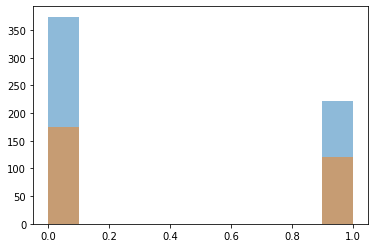

In [94]:
from sklearn.model_selection import train_test_split
train_data, X_test, y_train, y_test = train_test_split(train_data, y_train, test_size=0.33, random_state=42)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

In [95]:
train_data = train_data.drop("Survived",axis=1)
train_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
6,7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
718,719,3,"McEvoy, Mr. Michael",male,NaN,0,0,36568,15.5000,NaN,Q
685,686,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C
73,74,3,"Chronopoulos, Mr. Apostolos",male,26.0,1,0,2680,14.4542,NaN,C
882,883,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S


In [96]:
train_data["Pclass"].value_counts()

3    336
1    135
2    125
Name: Pclass, dtype: int64

In [97]:
train_data["Sex"].value_counts()

male      390
female    206
Name: Sex, dtype: int64

In [98]:
train_data["Embarked"].value_counts()

S    437
C    105
Q     53
Name: Embarked, dtype: int64

Atrybut Embarked mówi nam, gdzie pasażer zaokrętował: C = Cherbourg, Q = Queenstown, S = Southampton.

# Preprocessing pipeline

## Pipeline for numerical data:

Inputer:

In [99]:
from sklearn.base import BaseEstimator, TransformerMixin

# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [100]:
# A class to adjust data in Titanic dataset
class TitanicNumDataFitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X["Family"] = X.Parch + X.SibSp
        return X

**Pipeline** for numerical data:

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
        ("titanicfitter", TitanicNumDataFitter()),
        ("imputer", SimpleImputer(strategy="median")),
        ('standardscaler', StandardScaler())
    ])

In [102]:
num_pipeline.fit_transform(train_data)

array([[ 1.91349292, -0.46983664, -0.46399264,  0.38784185, -0.54476863],
       [-0.09452019, -0.46983664, -0.46399264, -0.31908053, -0.54476863],
       [-0.32621401,  0.34418265,  2.01618328,  0.18792449,  1.17312611],
       ...,
       [ 0.90948636,  1.15820195, -0.46399264, -0.34613654,  0.60049453],
       [-1.17575802,  0.34418265,  2.01618328,  1.71250117,  1.17312611],
       [-0.63513911, -0.46983664,  0.77609532,  0.8821286 ,  0.02786295]])

## **Pipeline** for categorical data:

Inputer

In [103]:
# A class to adjust data in Titanic dataset
class TitanicCatDataFitter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for c in X.columns:
            if c == "Name":
                X[c] = pd.Series(X[c].apply(lambda x: x.split(", ")[1].split(". ")[0]), index = X.index)
            elif c == "Cabin":
                X[c] = X[c].str[0].fillna("Null")
        return X

In [104]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [105]:
# Filler, which changes rare values to "Others" group
class GroupUniqueImputer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        norm_val_counts = pd.Series([X[c].value_counts(normalize = True) * 100 > self.threshold for c in X], index=X.columns)
        self.most_frequent_values_ = pd.Series([elem[:elem.sum()].index.tolist() for elem in norm_val_counts], index=X.columns)
        return self
    
    def transform(self, X, y=None):
        return pd.DataFrame(dict(zip(X.columns ,[X[c].apply(lambda x: 'Others' if not x in self.most_frequent_values_[c] else x) for c in X])), index = X.index)

**Pipeline** for categorical data

In [106]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["Pclass", "Sex", "Name", "Cabin"])),
        ("titanicfitter", TitanicCatDataFitter()),
        ("imputer", MostFrequentImputer()),
        ("filler", GroupUniqueImputer(0.5)), #value is a threshold in percentage. Values in columns change into "Others" if not exceed threshold
        ("cat_encoder", OneHotEncoder(sparse=False)),
        ('standardscaler', StandardScaler())
    ])

In [107]:
#cat_pipeline.fit_transform(train_data)

Concatenate two pipelines with FeatureUnion:

In [108]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

In [109]:
from sklearn.model_selection import StratifiedKFold

seed=123
kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle = True)

# Grid solutions

In [110]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action = 'once')

Linear Support Vector Classifier

In [111]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

pipe_1 = Pipeline([('preprocessing', preprocess_pipeline),  
#                  ('standardscaler', StandardScaler()), 
                 ('classifier', LinearSVC(C=1))])

param_grid_1 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_1 = GridSearchCV(pipe_1, param_grid_1, cv=kfold, return_train_score=True)

grid_1.fit(train_data, y_train)
grid_1.best_params_

{'classifier__C': 0.001}

Support Vector Classifier

In [112]:
pipe_2 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', SVC(C=1, probability=True))])

param_grid_2 = {
            'classifier__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100, "scale", "auto"]
}
    
grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(train_data, y_train)
grid_2.best_params_

{'classifier__C': 0.0001, 'classifier__gamma': 0.001}

Logistic Regression

In [113]:
from sklearn.linear_model import LogisticRegression

pipe_3 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', LogisticRegression(C=1))])

param_grid_3 = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(train_data, y_train)
grid_3.best_params_

{'classifier__C': 0.001}

k-Nearest neighbors

In [114]:
from sklearn.neighbors import KNeighborsClassifier

pipe_4 = Pipeline([('preprocessing', preprocess_pipeline), ('classifier', KNeighborsClassifier(n_neighbors=2, metric='euclidean'))])

param_grid_4 = {
            'classifier__n_neighbors': [2, 5, 10, 11, 12, 15],
            'classifier__metric': ['euclidean', 'cityblock']
}


grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(train_data, y_train)
grid_4.best_params_

{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 2}

DecisionTreeClassifier

In [115]:
from sklearn.tree import DecisionTreeClassifier

pipe_5 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', DecisionTreeClassifier())])

param_grid_5 = {
            'classifier__max_depth': [5,9,10,11,20,30],
            'classifier__min_samples_split': [2,3,5,10,20,30,40],
            'classifier__max_leaf_nodes': [3,4,10,14,15,16,20,30,40]
}


grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(train_data, y_train)
grid_5.best_params_

{'classifier__max_depth': 5,
 'classifier__max_leaf_nodes': 3,
 'classifier__min_samples_split': 2}

Random Forest

In [116]:
from sklearn.ensemble import RandomForestClassifier

pipe_6 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_6 = {'classifier__n_estimators': [10, 50, 100, 150],
              'classifier__max_leaf_nodes': [5, 10, 20],
              'classifier__max_depth': [10, 20, 30]
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(train_data, y_train)
grid_6.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 5,
 'classifier__n_estimators': 10}

Bagging Classifier

In [117]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_7 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', BaggingClassifier(
                                    DecisionTreeClassifier(random_state=42), n_estimators=500,
                                    max_samples=100, bootstrap=True, random_state=42))
                  ])

param_grid_7 = {'classifier__n_estimators': [10,50,100],
              'classifier__max_samples': [10,20]
             }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(train_data, y_train)
grid_7.best_params_



{'classifier__max_samples': 10, 'classifier__n_estimators': 10}

Extra Trees Classifier

In [118]:
from sklearn.ensemble import ExtraTreesClassifier

pipe_8 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_8 = {'classifier__n_estimators': [10, 50, 100],
              'classifier__max_leaf_nodes': [10, 20],
              'classifier__max_depth': [10, 20]
             }

grid_8 = GridSearchCV(pipe_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(train_data, y_train)
grid_8.best_params_

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 10,
 'classifier__n_estimators': 10}

Adaptive Boosting

In [119]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_9 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', AdaBoostClassifier(
                        DecisionTreeClassifier(max_depth=1), 
                        n_estimators=1, learning_rate=0.5, 
                        algorithm="SAMME.R", random_state=42)
                   )
                  ])


param_grid_9 = {'classifier__n_estimators': [50, 100, 200],
              'classifier__learning_rate': [0.1, 0.2,0.5,0.9, 1],
               'classifier__base_estimator__max_depth':[1,5,7,10,20]
             }

grid_9 = GridSearchCV(pipe_9, param_grid_9, cv=kfold, return_train_score=True)

grid_9.fit(train_data, y_train)
grid_9.best_params_

{'classifier__base_estimator__max_depth': 1,
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 50}

In [120]:
metrics.accuracy_score(y_test, grid_9.best_estimator_.predict(X_test))

0.8406779661016949

Gradient Boosting

In [121]:
from sklearn.ensemble import GradientBoostingClassifier

pipe_10 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', GradientBoostingClassifier(
                       n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_10 = {'classifier__n_estimators': [50, 100, 200],
              'classifier__learning_rate': [0.1, 0.2,0.5,0.9, 1]
             }

grid_10 = GridSearchCV(pipe_10, param_grid_10, cv=kfold, return_train_score=True)

grid_10.fit(train_data, y_train)
grid_10.best_params_

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 50}

Extreme Gradient Boosting (xgboost)

In [122]:
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost


pipe_11 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_11 = {
    'classifier__max_depth': randint(3, 11),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__n_estimators': randint(50, 400),
    'classifier__gamma': uniform(0,2),
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__subsample': uniform(0.5, 0.5),
    'classifier__min_child_weight': randint(1, 11)
}

grid_11 = RandomizedSearchCV(n_iter=100,estimator=pipe_11, 
                             param_distributions=param_grid_11, 
                      cv=kfold, 
                      return_train_score=True)

grid_11.fit(train_data, y_train)
grid_11.best_params_

{'classifier__colsample_bytree': 0.6169032072612065,
 'classifier__gamma': 1.3958343069777286,
 'classifier__learning_rate': 0.030926489323960527,
 'classifier__max_depth': 7,
 'classifier__min_child_weight': 3,
 'classifier__n_estimators': 361,
 'classifier__subsample': 0.6386635663911442}

In [123]:
metrics.accuracy_score(y_test, grid_11.best_estimator_.predict(X_test))

0.8305084745762712

Voting Classifier

In [124]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
                #('grid_10', grid_10.best_estimator_), 
                ('grid_6', grid_6.best_estimator_), 
                ('grid_9', grid_9.best_estimator_),
                ('grid_11', grid_11.best_estimator_),
               ],
    voting='soft')
voting_clf.fit(train_data, y_train);

In [125]:
metrics.accuracy_score(y_test, voting_clf.predict(X_test))

0.8338983050847457

In [126]:
from sklearn import  metrics


models = []
models.append((str(pipe_1.steps[-1][1]).split("(")[0], grid_1.best_estimator_))
models.append((str(pipe_2.steps[-1][1]).split("(")[0], grid_2.best_estimator_))
models.append((str(pipe_3.steps[-1][1]).split("(")[0], grid_3.best_estimator_))
models.append((str(pipe_4.steps[-1][1]).split("(")[0], grid_4.best_estimator_))
models.append((str(pipe_5.steps[-1][1]).split("(")[0], grid_5.best_estimator_))
models.append((str(pipe_6.steps[-1][1]).split("(")[0], grid_6.best_estimator_))
models.append((str(pipe_7.steps[-1][1]).split("(")[0], grid_7.best_estimator_))
models.append((str(pipe_8.steps[-1][1]).split("(")[0], grid_8.best_estimator_))
models.append((str(pipe_9.steps[-1][1]).split("(")[0], grid_9.best_estimator_))
models.append((str(pipe_10.steps[-1][1]).split("(")[0], grid_10.best_estimator_))
models.append((str(pipe_11.steps[-1][1]).split("(")[0], grid_11.best_estimator_))

precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("precision_score: {}".format(metrics.precision_score(y_test , model.predict(X_test)) ))
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    
    if (name == 'LinearSVC'):
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.decision_function(X_test)) ))            
    else:
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'LinearSVC'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

LinearSVC
precision_score: 0.7815126050420168
recall_score: 0.775
f1_score: 0.7782426778242678
accuracy_score: 0.8203389830508474
roc_auc_score: 0.8876190476190475
SVC
precision_score: 0.0
recall_score: 0.0
f1_score: 0.0
accuracy_score: 0.5932203389830508
roc_auc_score: 0.8843809523809524
LogisticRegression
precision_score: 0.9444444444444444
recall_score: 0.425
f1_score: 0.5862068965517241
accuracy_score: 0.7559322033898305
roc_auc_score: 0.886095238095238
KNeighborsClassifier
precision_score: 0.8202247191011236
recall_score: 0.6083333333333333
f1_score: 0.6985645933014353
accuracy_score: 0.7864406779661017
roc_auc_score: 0.8040238095238095
DecisionTreeClassifier
precision_score: 0.9206349206349206
recall_score: 0.48333333333333334
f1_score: 0.6338797814207651
accuracy_score: 0.7728813559322034
roc_auc_score: 0.8045714285714286
RandomForestClassifier
precision_score: 0.83
recall_score: 0.6916666666666667
f1_score: 0.7545454545454545
accuracy_score: 0.8169491525423729
roc_auc_score: 0.

In [127]:
import pandas as pd
d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=[model[0] for model in models])
df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,LinearSVC,0.781513,0.775000,0.778243,0.820339,0.887619
1,SVC,0.000000,0.000000,0.000000,0.593220,0.884381
2,LogisticRegression,0.944444,0.425000,0.586207,0.755932,0.886095
3,KNeighborsClassifier,0.820225,0.608333,0.698565,0.786441,0.804024
4,DecisionTreeClassifier,0.920635,0.483333,0.633880,0.772881,0.804571
5,RandomForestClassifier,0.830000,0.691667,0.754545,0.816949,0.880286
6,BaggingClassifier,0.846154,0.366667,0.511628,0.715254,0.849405
7,ExtraTreesClassifier,0.870588,0.616667,0.721951,0.806780,0.888357
8,AdaBoostClassifier,0.834862,0.758333,0.794760,0.840678,0.890381
9,GradientBoostingClassifier,0.855670,0.691667,0.764977,0.827119,0.892714


LinearSVC
SVC
LogisticRegression
KNeighborsClassifier
DecisionTreeClassifier
RandomForestClassifier
BaggingClassifier
ExtraTreesClassifier
AdaBoostClassifier
GradientBoostingClassifier
XGBClassifier


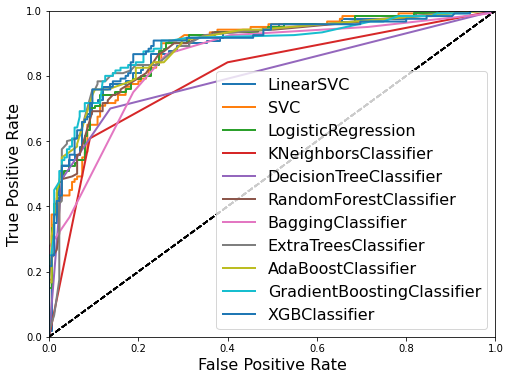

In [128]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
for name, model in models:
    print(name)
    if (name == 'LinearSVC'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()

In [129]:
# feature_names = ["Age", "SibSp", "Parch", "Fare", "Pclass_1", "Pclass_2", "Pclass_3", "Sex_0", "Sex_1", "Embarked_0", "Embarked_1", "Embarked_2"]
# plt.figure(figsize=(10, 10))
# n_features = len(grid_10.best_estimator_.named_steps['classifier'].feature_importances_)


# plt.barh(range(n_features), grid_10.best_estimator_.named_steps['classifier'].feature_importances_, align='center', alpha =0.5, label="GradientBoostingClassifier")
# plt.yticks(np.arange(n_features), feature_names)

# plt.barh(range(n_features), grid_11.best_estimator_.named_steps['classifier'].feature_importances_, align='center', alpha =0.5, label="XGBClassifier")
# plt.yticks(np.arange(n_features), feature_names)

# plt.legend()

In [130]:
df[df.accuracy_score == df.accuracy_score.max()]

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
8,AdaBoostClassifier,0.834862,0.758333,0.79476,0.840678,0.890381


In [131]:
# output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': voting_clf.predict(test_data)})
# output

In [132]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': [elem[1] for elem in models if elem[0] ==df[df.accuracy_score == df.accuracy_score.max()].Method.values[0]][0].predict(test_data)})
output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [133]:
output.to_csv(os.path.join(os.getcwd(), 'results', 'titanic_submission.csv'), index = False)
